In [1]:
import torch
import xarray as xr
import torch.nn as nn
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt

from sht_utils import *

cmap = 'turbo'

In [2]:
### Define Spectral Truncation Desired and Consistent
###    Gausian Grid
zw = 42
mw = 42
n_theta = 64
n_lamda = 128
###
###

In [3]:
### Grab Topography Data
###
url_topo = 'http://research.jisao.washington.edu/data_sets/elevation/elev.0.75-deg.nc'
ds_topo = xr.open_dataset(url_topo + '#mode=bytes', decode_times = False) # adding #mode=bytes because netcdf4 non-opendap URLrequeriment
del ds_topo['time']
data = ds_topo.data.squeeze()
data

<xarray.DataArray 'data' (lat: 241, lon: 480)>
[115680 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float32 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
Attributes:
    units:      m
    long_name:  m

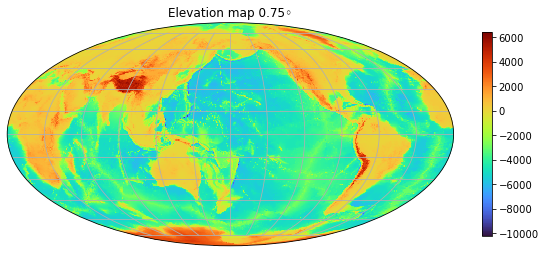

In [4]:
lon = np.linspace(-np.pi, np.pi, data.shape[1])
lat = np.linspace(np.pi/2., -np.pi/2., data.shape[0])
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
cs = ax.pcolormesh(Lon, Lat, data, cmap=cmap)
ax.set_title("Elevation map 0.75◦")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(cs, ax=ax, shrink=0.75)
plt.show()

In [5]:
# Setup necessary element for interpolation onto model Gaussian Grid
#
# First get the Gaussian latitudes on equally spaced longitudes
#
cost_lg, wlg = legendre_gauss_weights(n_theta, -1, 1)
lats = np.flip(np.arccos(cost_lg))
lats = -90+180*lats/(np.pi)
#
lons = np.linspace(0.0,360.0-360.0/n_lamda,n_lamda)
#
# foo below is used for interpolation
#
foo = np.zeros((n_theta,n_lamda))
dfoo = xr.Dataset({'foo': (['lat','lon'],foo)},
                    coords={'lat': lats, 'lon': lons})
#
import xesmf as xe
regridder_oi = xe.Regridder(data,dfoo,'bilinear')
regridder_oi

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_241x480_64x128.nc 
Reuse pre-computed weights? False 
Input grid shape:           (241, 480) 
Output grid shape:          (64, 128) 
Periodic in longitude?      False

In [6]:
topog_gg = regridder_oi(data)*9.8
topog_gg

<xarray.DataArray (lat: 64, lon: 128)>
array([[ 26836.791,  26836.805,  26836.809, ...,  26282.486,  26278.701,
         26276.994],
       [ 26283.6  ,  26283.6  ,  26596.34 , ...,  27043.734,  26903.805,
         26280.205],
       [ 26359.383,  26881.4  ,  29085.027, ...,  27185.201,  26951.127,
         26277.473],
       ...,
       [-27598.664, -29287.719, -27963.443, ..., -27094.443, -35776.293,
        -28934.87 ],
       [-34692.023, -34310.867, -35763.348, ..., -37032.047, -39376.332,
        -37823.223],
       [-43243.137, -43489.12 , -43495.902, ..., -39674.906, -40695.863,
        -42532.617]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

In [7]:
topog_gg = np.where(topog_gg < 0.0, 0.0, topog_gg)

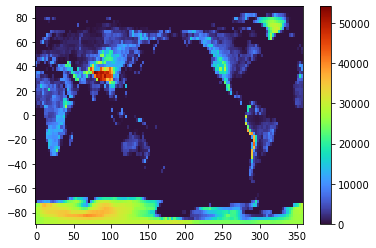

In [8]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, topog_gg, cmap=cmap)
plt.colorbar()

In [9]:
topog_gg_dev = torch.from_numpy(topog_gg)

In [10]:
# Instanciate Transforms:

In [11]:
#%%time
jmax = n_theta
imax = n_lamda
sht = RealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
isht = InverseRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
vsht = RealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
ivsht = InverseRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)

In [12]:
coeffs = sht(topog_gg_dev)

In [13]:
np.shape(coeffs)

torch.Size([42, 42])

In [14]:
topog_gg_r = isht(coeffs).cpu()
topog_gg_r

tensor([[28415.1562, 28598.7070, 28776.8906,  ..., 27839.7773, 28034.8926,
         28226.9609],
        [26790.3555, 27349.8945, 27888.2949,  ..., 24964.0117, 25599.0625,
         26207.4004],
        [27003.7305, 27608.7891, 28163.7129,  ..., 24667.5703, 25552.6113,
         26325.4297],
        ...,
        [  155.3691,   263.1907,   390.1067,  ...,   176.5369,    89.3547,
            89.5697],
        [ -159.2637,   -61.2395,    33.3505,  ...,  -436.2204,  -350.4234,
          -256.9218],
        [ -245.7325,  -199.3457,  -154.0330,  ...,  -386.9572,  -339.9984,
          -292.7673]])

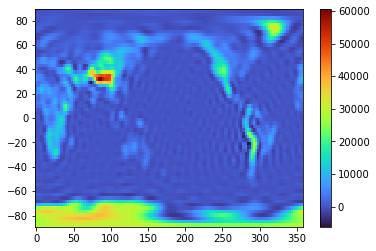

In [15]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, topog_gg_r, cmap=cmap)
plt.colorbar()

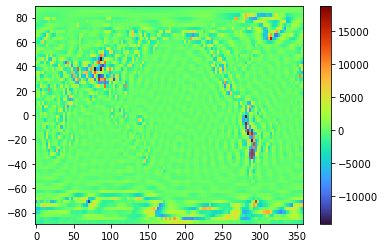

In [16]:
foo = (torch.from_numpy(topog_gg) - topog_gg_r)
plt.pcolormesh(Lon, Lat, foo, cmap=cmap)
plt.colorbar()

In [17]:
# Write out the spectral coefficients for topography to be read by
# the AGCM as a pickle file
#
torch.save(coeffs,'topog.spectral.pt')

In [18]:
#
#
# Surface temp used to derive 3-D temperature field for
# Newtonian Relaxation
#
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface/air.sig995.mon.mean.nc'
Dtemp = xr.open_dataset(ftemp,autoclose=True)
Dtemp
#
# Field above is monthly 0.995 sigma level data
# 

<xarray.Dataset>
Dimensions:  (lon: 144, time: 911, lat: 73)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-11-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

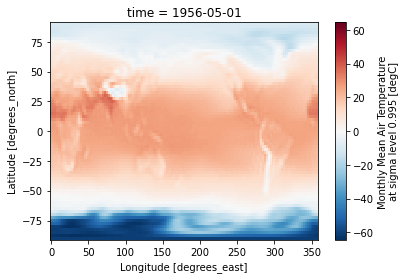

In [19]:
Dtemp.air[100,:,:].plot()

In [20]:
#
# Need to set up vertical structure of back-ground temp based on
# first sigma level in put. Will need model vertical structure
# from subs1_utils
#
# First Calculate Climatology
#
tsurf_climo = Dtemp.air.groupby('time.month').mean(dim='time')
#

In [21]:
# Then interpolate to Gaussian grid
#
regridder_oi2 = xe.Regridder(tsurf_climo[1,:,:],dfoo,'bilinear')
#
tsurf_feb = regridder_oi2(tsurf_climo[1,:,:])
#

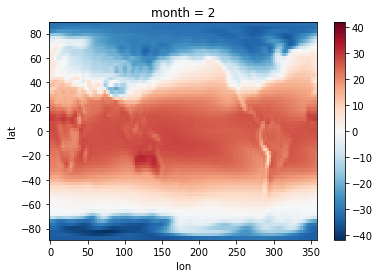

In [22]:
tsurf_feb.plot()

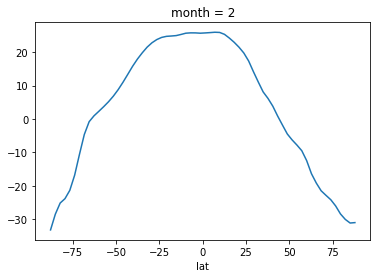

In [23]:
tsurf_feb_zonalmean = tsurf_feb.mean(dim='lon')
tsurf_feb_zonalmean.plot()

In [24]:
#
# Now generature the vertical strucuture of temperature
# will neeed model vertical structure (si(kmax))
#
from subs1_utils import *
#
kmax = 11
delsig, si, sl, sikap, slkap, cth1, cth2, r1b, r2b = bscst(kmax)
#
#
temp_spec = torch.from_numpy(np.zeros((kmax,zw,mw)))
temp_gg = np.zeros((kmax,n_theta,n_lamda))
#
#   Radiative equilibrium temperature
#       varying surface temperature decreasing with
#       height with a lapse rate dTe/dz approx = -rlaps degrees/m
#       to a stratospheric temperature of tstrat
#
rlaps=6.8*1.0e-03
h0 = 8.2e+03
tstrat = 205.0 # fixed stratospheric temperature
#
#for ii in range(n_lamda):
#    temp_gg[kmax-1,:,ii] = tsurf_feb_zonalmean[:].values + 273.16 # Uncomment if
                                                        # only using zonal mean surface
                                                        # temperature
temp_gg[kmax-1,:,:] = tsurf_feb.values + 273.16 # Uncomment if using full surface 
                                                 # temperature
for k in np.arange(1, kmax, 1, dtype=int):
    temp_gg[k,:,:] = temp_gg[kmax-1,:,:] + h0*rlaps*np.log(sl[k])
#
temp_gg = np.where(temp_gg < 205.0, 205.0, temp_gg)

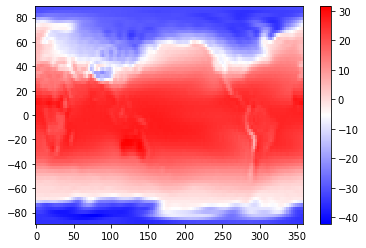

In [25]:
plt.pcolormesh(Lon, Lat, temp_gg[10,:,:]-273.16, cmap='bwr')
plt.colorbar()

In [26]:
temp_coeffs = torch.zeros((kmax,mw,zw),dtype=torch.complex128)
for k in range(kmax):
    temp_coeffs[k] = sht(torch.from_numpy(temp_gg[k])).cpu()

In [27]:
torch.save(temp_coeffs,'temp.spectral.pt')

In [28]:
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface_gauss/pres.sfc.mon.mean.nc'
Dps = xr.open_dataset(ftemp,autoclose=True)
Dps

<xarray.Dataset>
Dimensions:  (lon: 192, lat: 94, time: 911)
Coordinates:
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-11-01
Data variables:
    pres     (time, lat, lon) float32 ...
Attributes:
    Conventions:                     COARDS
    description:                     Data is from NCEP initialized reanalysis...
    platform:                        Model
    NCO:                             20121013
    history:                         Created 2011/06/28 by ESRL/PSD Web & Dat...
    title:                           monthly mean pres.sfc from the NCEP Rean...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

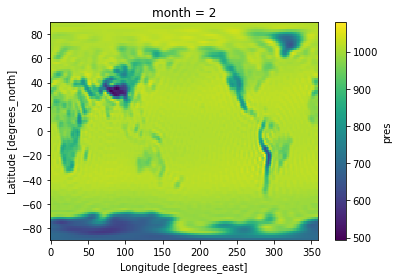

In [29]:
psmean = Dps.pres.groupby('time.month').mean(dim='time')
(psmean[1]/100).plot()

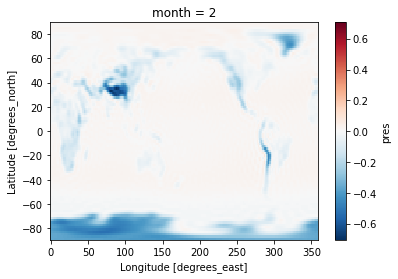

In [30]:
lnps = np.log(psmean[1]/(100*1000))
lnps.plot()

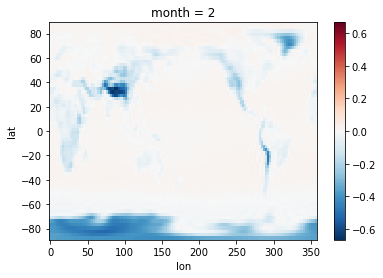

In [31]:
# Then interpolate to Gaussian grid
#
regridder_oi2 = xe.Regridder(lnps,dfoo,'bilinear')
#
lnps_feb = regridder_oi2(lnps)
lnps_feb.plot()
#

In [32]:
lnps_coeffs = sht(torch.from_numpy(lnps_feb.values)).cpu()
torch.save(lnps_coeffs,'lnps.spectral.pt')

In [33]:
#
# possible prescribed heating
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc'
Dprec = xr.open_dataset(ftemp,autoclose=True)
Dprec

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 538)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes: (12/13)
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    ...                              ...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    version:                         V2311
    history:                         update 11/2023 V2311
    data_modified:                   2023-11-07
    DODS_EXTRA.Unlimited_Dimension:  time

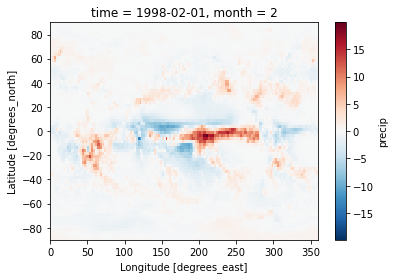

In [34]:
#
prec_clim = Dprec.precip.groupby('time.month').mean(dim='time')
prec_anom = Dprec.precip.groupby('time.month') - prec_clim
#
rain_anom = prec_anom.sel(time='1998-02-01')
rain_anom.plot()

In [35]:
#
# Convert rainfall anomaly into a hearting rate that can
# applied to the temperature equation (i.e., Q/Cp) and distribute
# in the vertical
#
vert_struc = np.zeros(kmax) # whatever user wants
#                                 kmax is lowest level and
#                                 0 is the upper most level of
#                                 the atmosphere
heat = torch.zeros((kmax,jmax,imax),dtype=torch.float64)
#
vert_struc[0] = 0.0
vert_struc[1] = 0.1
vert_struc[2] = 0.2
vert_struc[3] = 1.5
vert_struc[4] = 1.9
vert_struc[5] = 1.5
vert_struc[6] = 0.9
vert_struc[7] = 0.5
vert_struc[8] = 0.2
vert_struc[9] = 0.1
vert_struc[10] = 0.0
#
# Need to ensure that vertical integral normalizes to 1.0
rnorm = (vert_struc*delsig).sum()
vert_struc = vert_struc/rnorm
#
# interpolate to Gaussian grid
#
regridder_oi2 = xe.Regridder(rain_anom,dfoo,'bilinear')
#
tmp = regridder_oi2(rain_anom)
#
# convert to heating and multiple by vertical structure
#
Lv = 2.5e+06
rhow = 1000.0
Cp = 1005.0
Ps = 101325.0
grav = 9.8
beta = (Lv*rhow/Cp)*(grav/Ps)/(1000.0*86400.0)
for k in range(kmax):
    heat[k,:,:] = (torch.from_numpy(tmp[:,:].values*vert_struc[k]*beta)) # in K/sec

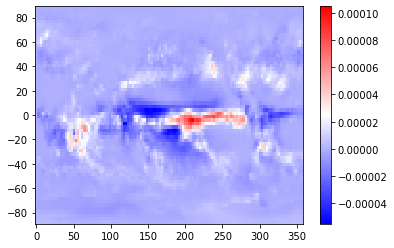

In [36]:
#
plt.pcolormesh(Lon, Lat, heat[4], cmap='bwr')
plt.colorbar()

In [37]:
#
torch.save(heat,'heat.ggrid.pt')